## Imports

In [1]:
import random
import nltk
import pickle
import numpy as np
import pandas as pd
import regex as re
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline
from tqdm.auto import tqdm
from dotenv import load_dotenv
from expertai.nlapi.cloud.client import ExpertAiClient

In [2]:
SEED_FOR_RANDOM = 1138
YEARS = list(range(1930, 2018))
YEARS_2 = list(range(2001,2018))

# 1. Data preprocessing

## Dataset

In [51]:
df = pd.read_csv("wiki_movie_plots_deduped.csv")
df = df[df["Origin/Ethnicity"] == "American"]

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17377 entries, 0 to 17376
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      17377 non-null  int64 
 1   Title             17377 non-null  object
 2   Origin/Ethnicity  17377 non-null  object
 3   Director          17377 non-null  object
 4   Cast              17060 non-null  object
 5   Genre             17377 non-null  object
 6   Wiki Page         17377 non-null  object
 7   Plot              17377 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.2+ MB


## Preprocessing the plots

In [4]:
def remove_brackets(string):
    return re.sub("(\[\d+\]|\(.*\))", "", string)

In [5]:
def remove_brackets_in_list(list_of_strings):
    return [remove_brackets(string) for string in list_of_strings]

## Group plots by year of creation

In [6]:
def group_plots_by_year(df):
    return df.groupby("Release Year")["Plot"].apply(
        lambda x: [remove_brackets(plot) for plot in x.tolist()])

In [7]:
plots_by_year = group_plots_by_year(df)

## Extract samples of plots

In [8]:
def chunker(full_text, chunk_size=9000):
    tokenized_text = nltk.tokenize.sent_tokenize(full_text)
    chunked_text = []
    while len(tokenized_text) > 0:
        character_sum = 0
        chunk = []
        counter = 0
        while character_sum <= chunk_size:
            try:
                chunk.append(tokenized_text[counter])
                character_sum += len(tokenized_text[counter])
                counter += 1
            except IndexError:
                break
        chunked_text.append(" ".join(chunk))
        tokenized_text = tokenized_text[counter:]
    return chunked_text

In [9]:
def plot_sampler(list_of_plots, chunk_size=500, number_of_samples=100, seed_for_random=SEED_FOR_RANDOM):
    random.seed(seed_for_random)
    sampled_plots = random.sample(list_of_plots, number_of_samples)
    samples = [random.choice(chunker(plot, chunk_size=chunk_size)) for plot in sampled_plots]
    return samples

# 2. API Calls

## Make the API Calls

In [10]:
load_dotenv()

True

### Full analysis

In [11]:
def nl_api_full(string, language="en"):
    client = ExpertAiClient()
    api_obj = client.full_analysis(body={"document": {"text": string}},
                                   params={"language": language})
    return api_obj

### Classification analysis

In [12]:
def nl_api_classification(string, taxonomy, language="en"):
    client = ExpertAiClient()
    api_obj = client.classification(body={"document": {"text": string}},
                                    params={"taxonomy": taxonomy, "language": language})
    return api_obj

## Process multiple samples

In [13]:
def process_multiple_samples(year, plots_by_year):
    full_api_objs = []
    iptc_api_objs = []
    emotional_api_objs = []
    samples_list = plot_sampler(plots_by_year[year])
    for _ in range(len(samples_list)):
        a_sample = samples_list[_]
        full_api_obj_for_sample = nl_api_full(a_sample)
        full_api_objs.append(full_api_obj_for_sample)
        iptc_api_obj_for_sample = nl_api_classification(a_sample, taxonomy="iptc")
        iptc_api_objs.append(iptc_api_obj_for_sample)
        emotional_api_obj_for_sample = nl_api_classification(a_sample, taxonomy="emotional-traits")
        emotional_api_objs.append(emotional_api_obj_for_sample)
    return full_api_objs, iptc_api_objs, emotional_api_objs

In [14]:
def append_api_objs_by_year(plots_by_year, api_objs_by_year=0, years_list=YEARS,
                            output_pickle="api_objs_by_year.p"):
    api_objs_by_year = {} if api_objs_by_year == 0 else api_objs_by_year
    for year in tqdm(years_list):
        year_full_api_objs, year_iptc_api_objs, year_emotional_api_objs = \
        process_multiple_samples(year, plots_by_year)
        api_objs_by_year[year] = (year_full_api_objs, year_iptc_api_objs, year_emotional_api_objs)
        pickle.dump(api_objs_by_year, open(output_pickle, "wb"))
    return api_objs_by_year

In [15]:
# api_objs_by_year = {}
api_objs_by_year = pickle.load(open("api_objs_by_year.p", "rb"))

In [16]:
api_objs_by_year = append_api_objs_by_year(plots_by_year, api_objs_by_year, years_list=YEARS_2)

  0%|          | 0/17 [00:00<?, ?it/s]

# 3. Data processing

## Extract topic and category scores

In [17]:
def extract_scores_by_topic(full_api_obj):
    scores_by_topic = {}
    for topic in full_api_obj.topics:
        scores_by_topic[topic.label] = topic.score
    return scores_by_topic

def extract_scores_by_lemma(full_api_obj):
    scores_by_lemma = {}
    for lemma in full_api_obj.main_lemmas:
        scores_by_lemma[lemma.value] = lemma.score
    return scores_by_lemma

def extract_scores_by_syncon(full_api_obj):
    scores_by_syncon = {}
    for syncon in full_api_obj.main_syncons:
        scores_by_syncon[syncon.lemma] = syncon.score
    return scores_by_syncon
        
def extract_sentiment_score(full_api_obj):
    sentiment = full_api_obj.sentiment.overall
    return sentiment

def extract_scores_by_category(category_api_obj):
    scores_by_category = {}
    for category in category_api_obj.categories:
        scores_by_category[category._label] = category._score
    return scores_by_category

## Combine and sort dictionaries

In [18]:
def merge_dictionaries(dictionary_1, dictionary_2):
    merged_dictionary = dictionary_2
    for key, value in dictionary_1.items():
        if key in dictionary_2.keys():
            merged_dictionary[key] = dictionary_2[key] + value
        else:
            merged_dictionary[key] = value
    return merged_dictionary

In [19]:
def sort_dictionary(dictionary, by_value=True, reverse=True):
    index_of_item_to_sort_by = 1 if by_value else 0
    sorted_dictionary = {key: value for key, value in sorted(
        dictionary.items(),
        key = lambda item: item[index_of_item_to_sort_by],
        reverse = reverse
    )}
    return sorted_dictionary

In [20]:
def aggregate_sentiment_for_a_year(full_api_objs_for_year):
    sentiment_scores = [
        extract_sentiment_score(full_api_obj)
        for full_api_obj in full_api_objs_for_year
    ]
    aggregated_scores = {"median": np.median(sentiment_scores),
                         "mean": np.mean(sentiment_scores)}
    return aggregated_scores

def aggregate_tokens_for_a_year(api_objs_for_year, token_type):
    tokens_for_a_year = {}
    for api_obj in api_objs_for_year:
        if token_type == "main syncons":
            tokens_for_sample = extract_scores_by_syncon(api_obj)
        elif token_type == "main lemmas":
            tokens_for_sample = extract_scores_by_lemma(api_obj)
        elif token_type == "api topics":
            tokens_for_sample = extract_scores_by_topic(api_obj)
        elif token_type == "categories":
            tokens_for_sample = extract_scores_by_category(api_obj)
        else:
            print("Unrecognized token type.")
            break
        tokens_for_a_year = merge_dictionaries(
            tokens_for_sample, tokens_for_a_year)
    return sort_dictionary(tokens_for_a_year)

In [21]:
def extract_data_for_a_year(api_objs_by_year, year):
    data_for_a_year = {}
    full_api_objs_for_year = api_objs_by_year[year][0]
    iptc_api_objs_for_year = api_objs_by_year[year][1]
    emot_api_objs_for_year = api_objs_by_year[year][2]
    sentiment_scores_for_year = aggregate_sentiment_for_a_year(
        full_api_objs_for_year)
    data_for_a_year["sentiment scores"] = sentiment_scores_for_year
    for token_type in ["api topics", "main lemmas", "main syncons"]:
        token_scores_for_year = aggregate_tokens_for_a_year(
            full_api_objs_for_year, token_type)
        data_for_a_year[token_type] = token_scores_for_year
    iptc_topics_for_year = aggregate_tokens_for_a_year(
        iptc_api_objs_for_year, "categories")
    data_for_a_year["iptc topics"] = iptc_topics_for_year
    emotional_traits_for_year = aggregate_tokens_for_a_year(
        emot_api_objs_for_year, "categories")
    data_for_a_year["emotional traits"] = emotional_traits_for_year
    return data_for_a_year

In [22]:
def extract_data_for_year_range(api_objs_by_year, year_range):
    data_for_year_range = {}
    year_range = sorted(year_range)
    for year in year_range:
        data_for_year = extract_data_for_a_year(api_objs_by_year, year)
        data_for_year_range[year] = data_for_year
    return data_for_year_range

In [23]:
data_by_year = extract_data_for_year_range(api_objs_by_year, YEARS)

## Collect data by year

In [24]:
def extract_token_scores_by_year(data_by_year, token, token_type):
    token_scores = []
    for _, data in data_by_year.items():
        data_for_token_type = data[token_type]
        if token in data_for_token_type.keys():
            token_scores.append(data[token_type][token])
        else:
            token_scores.append(0)
    return token_scores

def extract_sentiment_scores_by_year(data_by_year, value_type):
    sentiment_scores = []
    for _, data in data_by_year.items():
        sentiment_scores.append(data["sentiment scores"][value_type])
    return sentiment_scores

def extract_number_of_unique_tokens_by_year(data_by_year, token_type):
    number_of_tokens = []
    for _, data in data_by_year.items():
        if token_type in data.keys():
            number_of_tokens.append(len(data[token_type]))
        else:
            number_of_tokens.append(0)
    return number_of_tokens

# 4. Visualization

In [25]:
def smoothen_values(x, y, interval, s_factor):
    x = np.array(x)
    y = np.array(y)
    spline = UnivariateSpline(x, y/np.max(y),
                              s=float(len(y))*s_factor)
    smooth_x = np.linspace(x.min(), x.max(), interval)
    smooth_y = spline(smooth_x)*np.max(y)
    return smooth_x, smooth_y

def draw_plot(y_data, years, color_1, color_2, plot_title,
              add_fill, interval, s_factor):
    ax = plt.subplot()
    sns.set_style("whitegrid")
    sns.lineplot(x=years, y=y_data,
                 linestyle="dashed",
                 linewidth=1,
                 color=color_1)
    smooth_years, smooth_data = smoothen_values(years, y_data,
                                                interval, s_factor)
    sns.lineplot(x=smooth_years, y=smooth_data, linewidth=4, color=color_2)
    if add_fill:
        plt.fill_between(smooth_years, smooth_data, alpha=0.2, color=color_2)
    ax.set_xticks(years[::5])
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=40)
    plt.title(plot_title)
    plt.show()

In [26]:
def plot_scores(data_by_year,
                token,
                token_type,
                color_1="#004b23",
                color_2="#004b23",
                plot_title="",
                add_fill=True,
                interval=20,
                s_factor=0.017):
    if plot_title == "":
        plot_title = f'Scores for "{token}" ({token_type.capitalize()})'
    scores = extract_token_scores_by_year(data_by_year, token, token_type)
    years = list(data_by_year.keys())
    plt.figure(figsize=(14,7))
    draw_plot(scores, years, color_1, color_2, plot_title,
              add_fill, interval, s_factor)
    plt.clf()

def plot_sentiment(data_by_year,
                   color_1="#9B1D20",
                   color_2="#3D2B3D",
                   value_type="median",
                   plot_title="",
                   add_fill=False,
                   interval=20,
                   s_factor=0.017):
    if plot_title == "":
        plot_title = f"{value_type.capitalize()} sentiment score per year"
    scores = extract_sentiment_scores_by_year(data_by_year, value_type)
    years = list(data_by_year.keys())
    plt.figure(figsize=(14,7))
    draw_plot(scores, years, color_1, color_2, plot_title,
              add_fill, interval, s_factor)
    plt.clf()

def plot_unique_tokens(data_by_year,
                       token_type,
                       color_1="#336699",
                       color_2="#86BBD8",
                       plot_title="",
                       add_fill=False,
                       interval=20,
                       s_factor=0.017):
    if plot_title == "":
        plot_title = f"Number of unique {token_type.title()} per year"
    scores = extract_number_of_unique_tokens_by_year(data_by_year, token_type)
    years = list(data_by_year.keys())
    plt.figure(figsize=(14,7))
    draw_plot(scores, years, color_1, color_2, plot_title, add_fill,
              interval, s_factor)
    plt.clf()

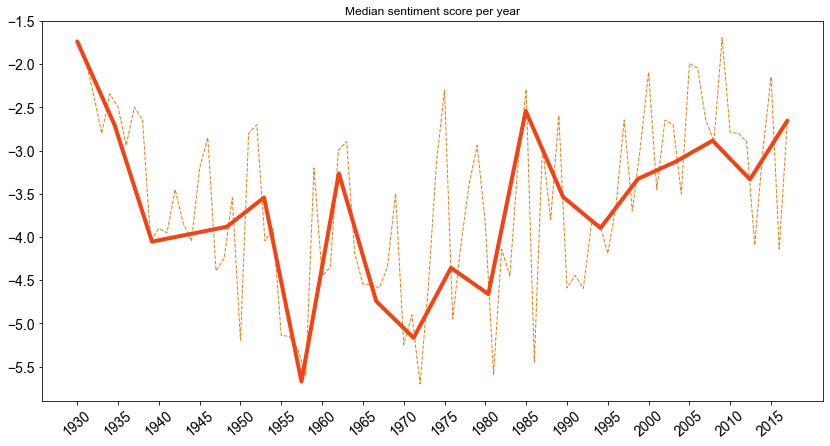

<Figure size 432x288 with 0 Axes>

In [27]:
plot_sentiment(data_by_year, value_type="median", color_1="#EC7D10", color_2="#F34213")

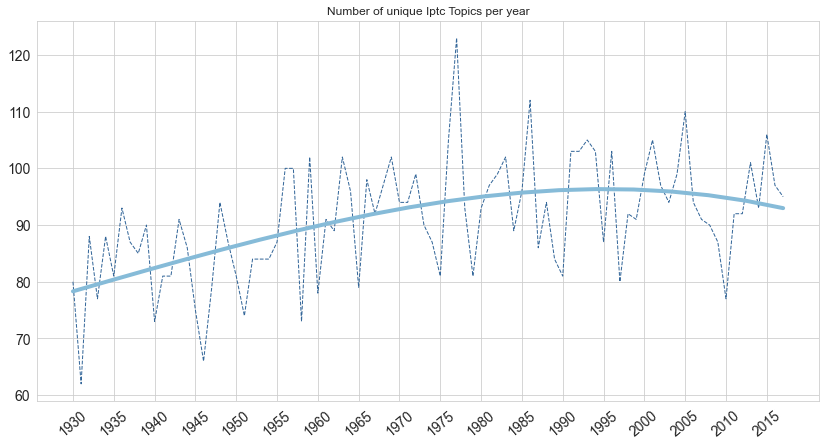

<Figure size 432x288 with 0 Axes>

In [28]:
plot_unique_tokens(data_by_year, token_type="iptc topics")

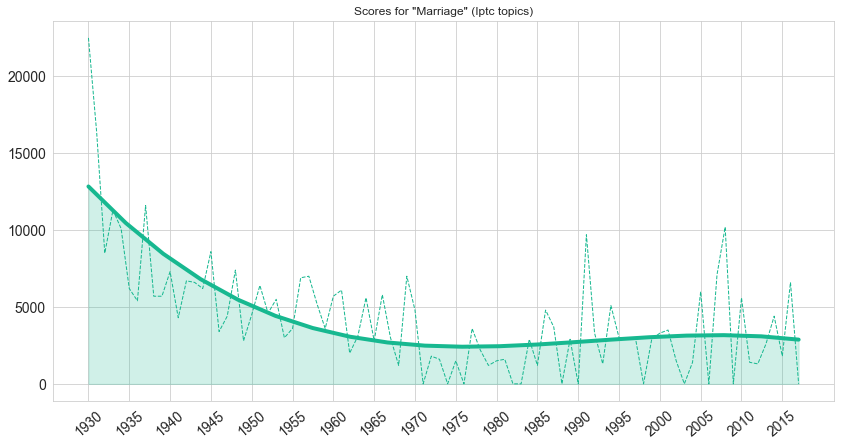

<Figure size 432x288 with 0 Axes>

In [59]:
plot_scores(data_by_year, "Marriage", "iptc topics", color_1="#17B890", color_2="#17B890")

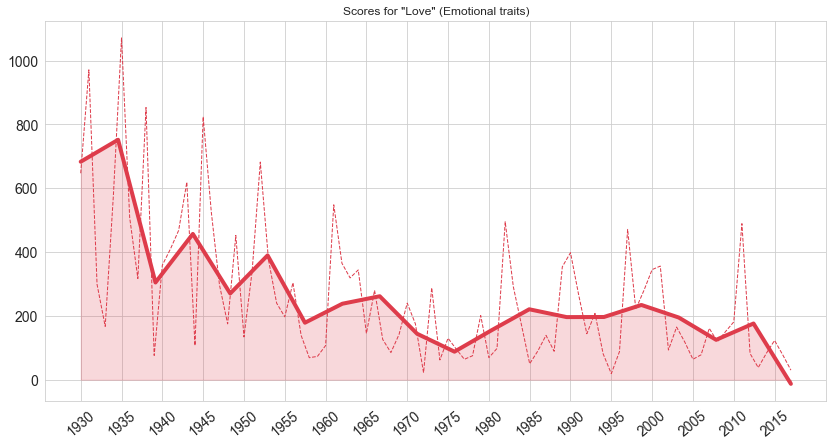

<Figure size 432x288 with 0 Axes>

In [30]:
plot_scores(data_by_year, "Love", "emotional traits", color_1="#DE3C4B", color_2="#DE3C4B")

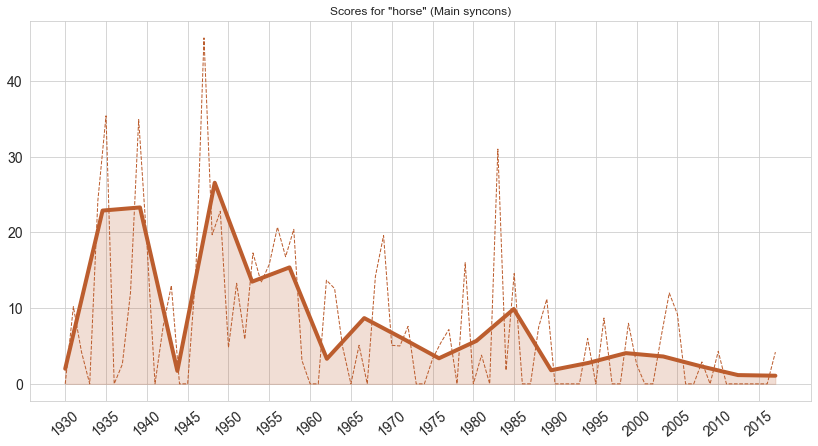

<Figure size 432x288 with 0 Axes>

In [31]:
plot_scores(data_by_year, "horse", "main syncons", color_1="#BC5D2E", color_2="#BC5D2E")

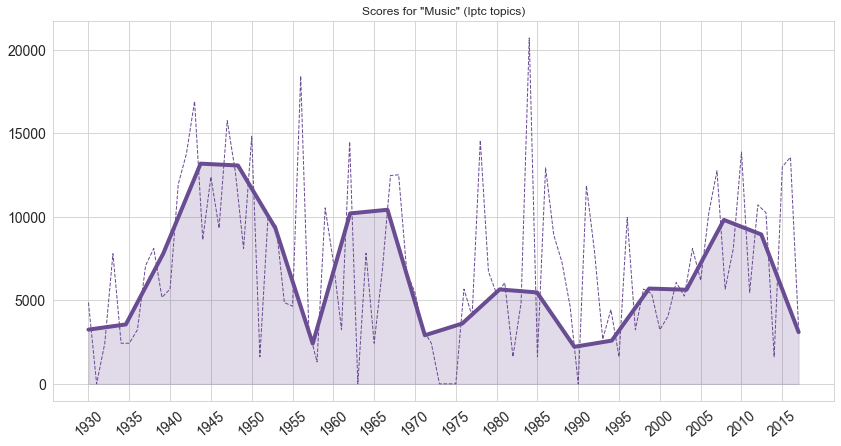

<Figure size 432x288 with 0 Axes>

In [57]:
plot_scores(data_by_year, "Music", "iptc topics", color_1="#6A4C93", color_2="#6A4C93")

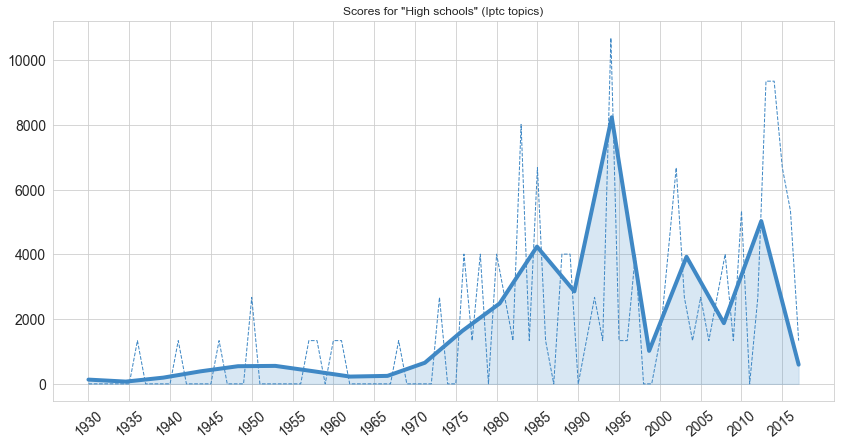

<Figure size 432x288 with 0 Axes>

In [33]:
plot_scores(data_by_year, "High schools", "iptc topics", color_1="#3F88C5", color_2="#3F88C5")

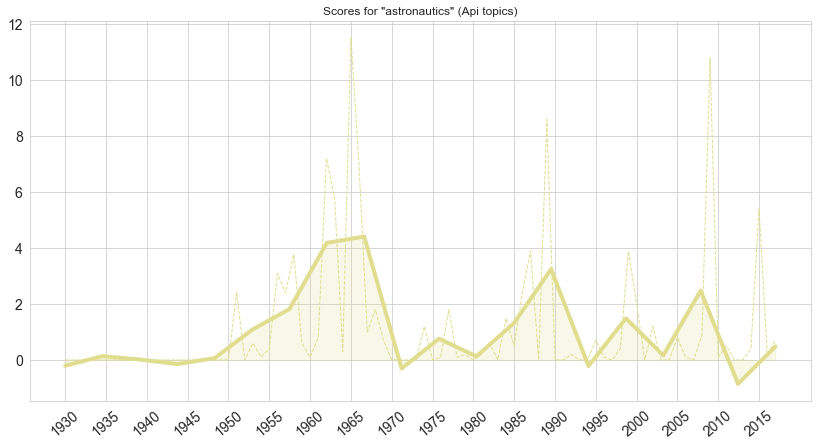

<Figure size 432x288 with 0 Axes>

In [34]:
plot_scores(data_by_year, "astronautics", "api topics", color_1="#E1DD8F", color_2="#E1DD8F")